# Qiskit Patterns

In this how-to we will learn about Qiskit Patterns and quantum approximate optimization. Qiskit Patterns define a four-step process for running algorithms on a quantum computer:

1. **Map** our classical problem to abstract quantum circuits and operators
2. **Optimize** problem for quantum execution
3. **Execute** on a quantum computer
4. **Post-process**, return result in classical format

We will apply the patterns to the context of **combinatorial optimization** and show how to solve the **Max-Cut** problem using the **Quantum Approximate Optimization Algorithm (QAOA)**, a hybrid (quantum-classical) iterative method. 

# Part 1: (Small-scale) Qiskit Pattern applied to Max-Cut

Max-Cut is a hard to solve optimization problem with applications in clustering, network science, and statistical physics. In Max-Cut, we want to partition the nodes of a graph into to sets such that the number of edges traversed by this cut is maximum.


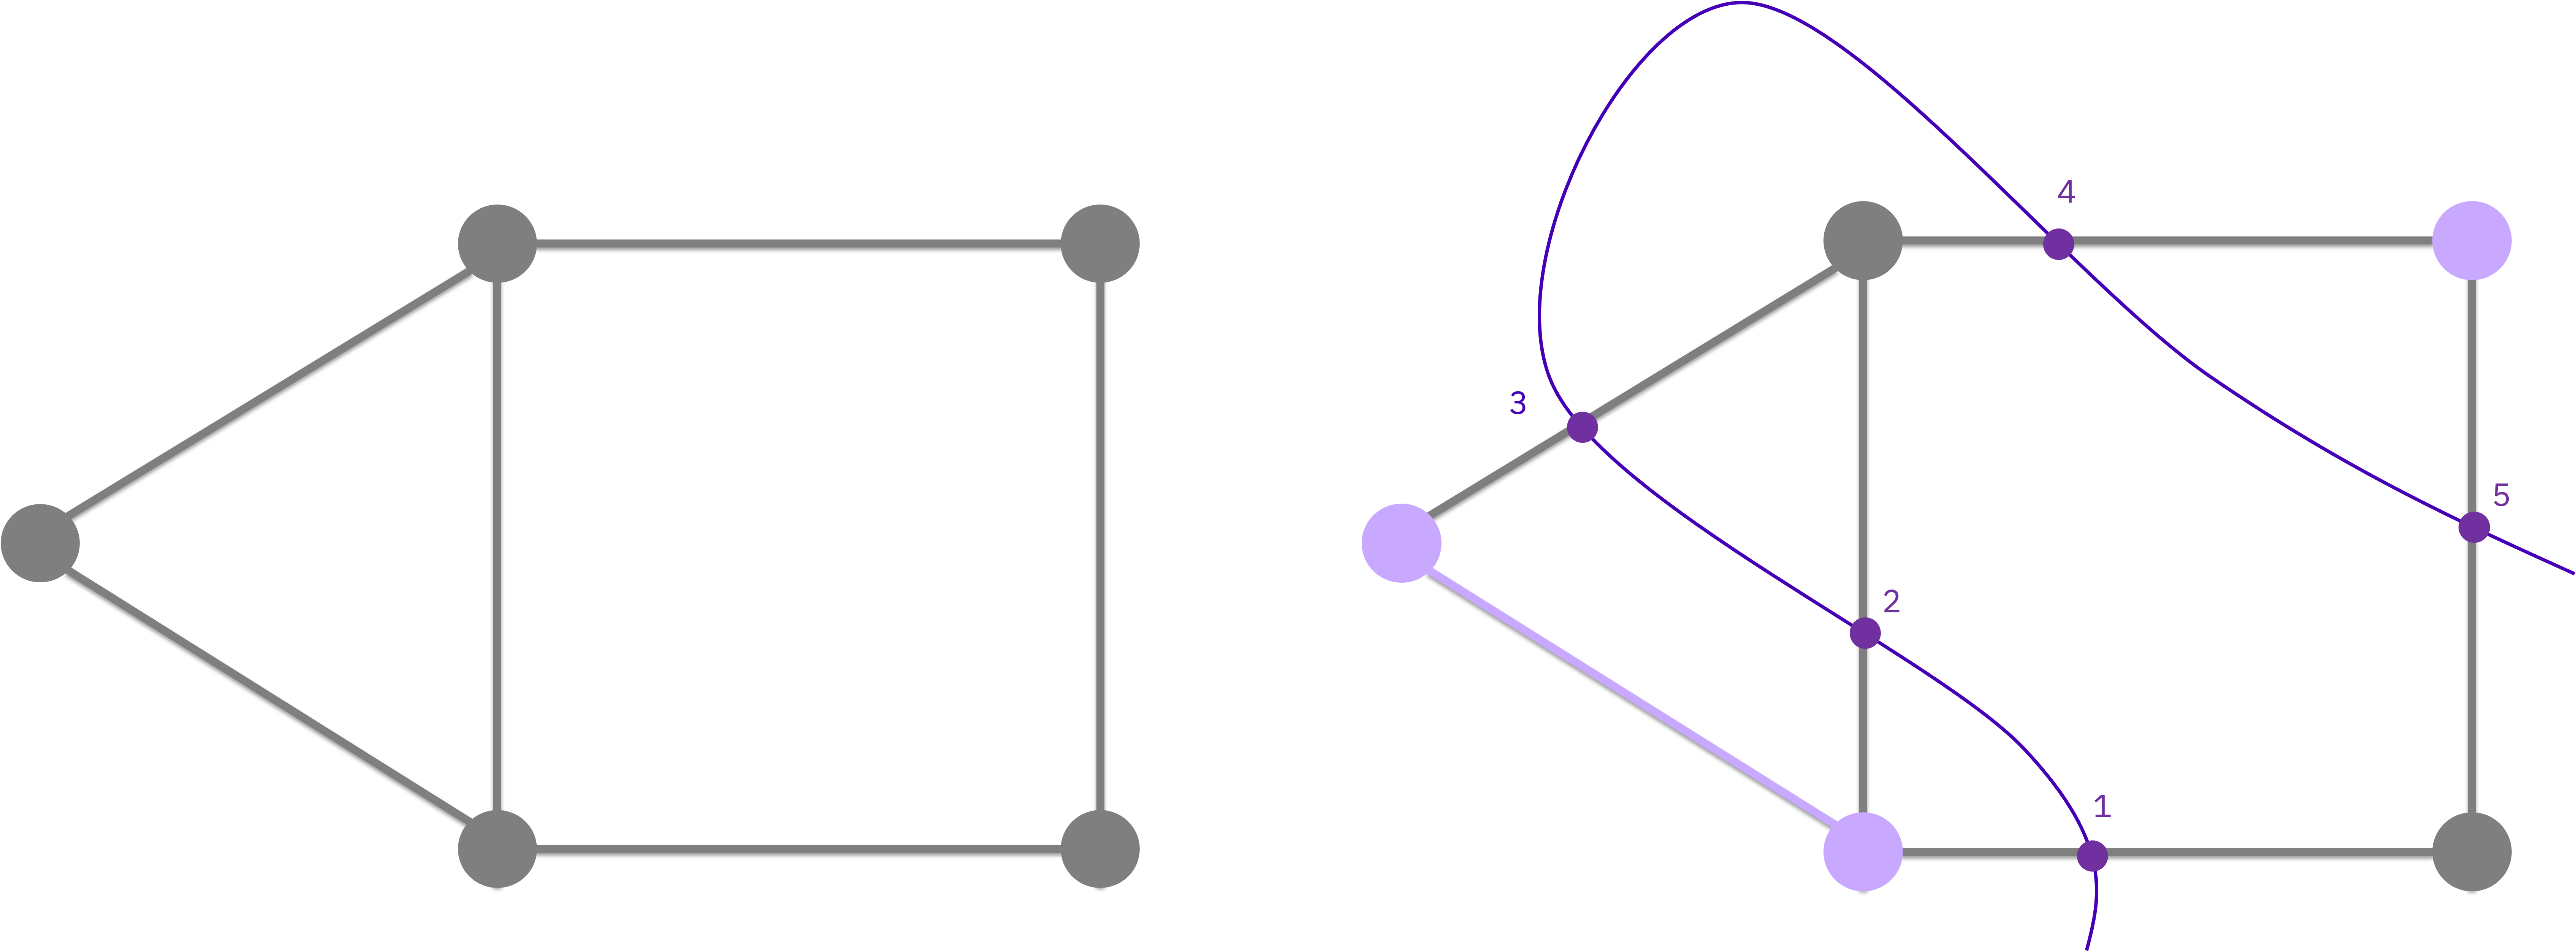

The workflow starts with a problem defined as a weighted graph:

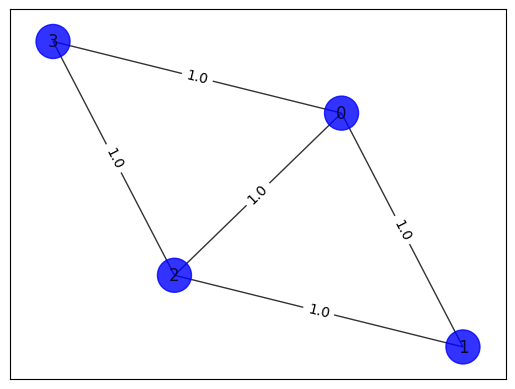

In [1]:
from demo_src.graph import generate_demo_graph, draw_graph

demo_graph = generate_demo_graph()
draw_graph(demo_graph)

Formally, it's a classical combinatorial optimization problem with the form

\begin{align}
\min_{x\in \{0, 1\}^n}f(x)
\end{align}

Where the vector $x$ are the $n$ decision variables that correspond to every node of the graph. In this case, we have $n=4$, and each node can be 0 or 1, included or not included in the cut. The minimum of $f(x)$ in this case will be when the number of edges traversed by the cut are maximal.

As you can see, there is nothing relating to quantum computing yet. We need to reformulate this problem into something that a quantum computer can understand.

## 1. Map the classical inputs to a quantum problem

### Graph &rarr; Qubo

The first step of the mapping is a notation change, can express our problem in Quadratic Unconstrained Binary Optimization notation:

\begin{align}
\min_{x\in \{0, 1\}^n}x^T Q x,
\end{align}

where $Q$ is a $n\times n$ matrix of real numbers. 

In [2]:
from demo_src.map import map_graph_to_qubo

qubo = map_graph_to_qubo(demo_graph)
print(qubo.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



### QUBO &rarr; Ising Hamiltonian

To start, we will convert the binary variables $x_i$ to variables $z_i\in\{-1, 1\}$ by doing

\begin{align}
x_i = \frac{1-z_i}{2}.
\end{align}

Here, for example, we see that if $x_i$ is $0$ then $z_i$ is $1$. When we substitute the $x_i$'s for the $z_i$'s in the QUBO above, we obtain the equivalent formulations for our optimization task

\begin{align}
\min_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \min_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

The details of the computation are shown in Appendix A below. Here, $b$ depends on $Q$. Note that to obtain $z^TQz + b^Tz$ we dropped an irrelevant factor of 1/4 and a constant offset of $n^2$ which do not play a role in the optimization. Now, to obtain a quantum formulation of the problem we promot the $z_i$ variables to a Pauli $Z$ matrix, i.e., a $2\times 2$ matrix of the form

\begin{align}
Z_i = \begin{pmatrix}1 & 0 \\ 0 & -1\end{pmatrix}.
\end{align}

When we substitute these matrices in the QUBO above we obtain the following Hamiltonian

\begin{align}
H_C=\sum_{ij}Q_{ij}Z_iZ_j + \sum_i b_iZ_i.
\end{align}

We refer to this Hamiltonian as the **cost function Hamiltonian**. It has the property that its gound state corresponds to the solution that **minimizes the cost function $f(x)$**.
Therefore, to solve our optimization problem we now need to prepare the ground state of $H_C$ (or a state with a high overlap with it) on the quantum computer. Then, sampling from this state will, with a high probability, yield the solution to $min f(x)$.

In [3]:
from demo_src.map import map_qubo_to_ising

cost_hamiltonian, offset = map_qubo_to_ising(qubo)

print("Offset:", offset)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Offset: -2.5
Cost Function Hamiltonian: SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### Ising Hamiltonian &rarr; Quantum Circuit

The Hamiltonian $H_c$ obtained from step 1 contains the quantum definition of our problem. We will now create a quantum circuit that will help us *sample* good solutions form the quantum computer. The QAOA is inspired from quantum annealing and proceeds by applying alternating layers of operators in the quantum cirucit.

![image.png](attachment:e647be6f-28e8-4985-9f12-9a67ee480665.png)

Losely speaking, the idea is to start in the ground state of a known system, $H^{\otimes n}|0\rangle$ above, and then steer the system into the ground state of the cost operator that we are interested in. This is done by applying the operators $\exp\{-i\gamma_k H_C\}$ and $\exp\{-i\beta_k H_m\}$ with the right angles $\gamma_1,...,\gamma_p$ and $\beta_1,...,\beta_p~$. 

We can generate a quantum circuit  that is **parametrized** by these angles. In this case we will try an example with 1 QAOA layer that contains two parameters: $\gamma_0$ and $\beta_0$.

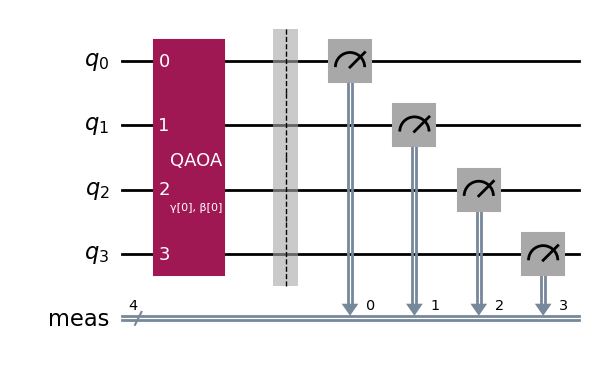

In [4]:
from demo_src.map import map_ising_to_circuit

ansatz = map_ising_to_circuit(cost_hamiltonian, num_layers=1)
ansatz.draw('mpl')

## 2. Optimize problem for quantum execution

Step 2 of the Qiskit Patterns focuses on preparing the circuit for optimal quantum execution through **transpilation**. The Qiskit library offers a series of **Transpilation Passes** that cater to a wide range of circuit transformations. We don't only want to get a circuit, but we want to make sure that the circuit is **optimized** for our purpose. Transpilation may involve many steps. Some of these steps are pointed out below.

* **Intiall mapping** of the qubits in the circuit (i.e. decision variables) to physical qubits on the device.
* **Unrolling** of the instructions in the quantum circuit to the hardware native instructions that the backend understands.
* **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another.
* **Error supression** by adding single-qubit gates to supress noise with dynamical decoupling.
* ...

As you can see there are many steps in the transpilation process. We will not go through these steps in detail here but instead load a pre-optimized quantum circuit that is ready to be run on the hardware.

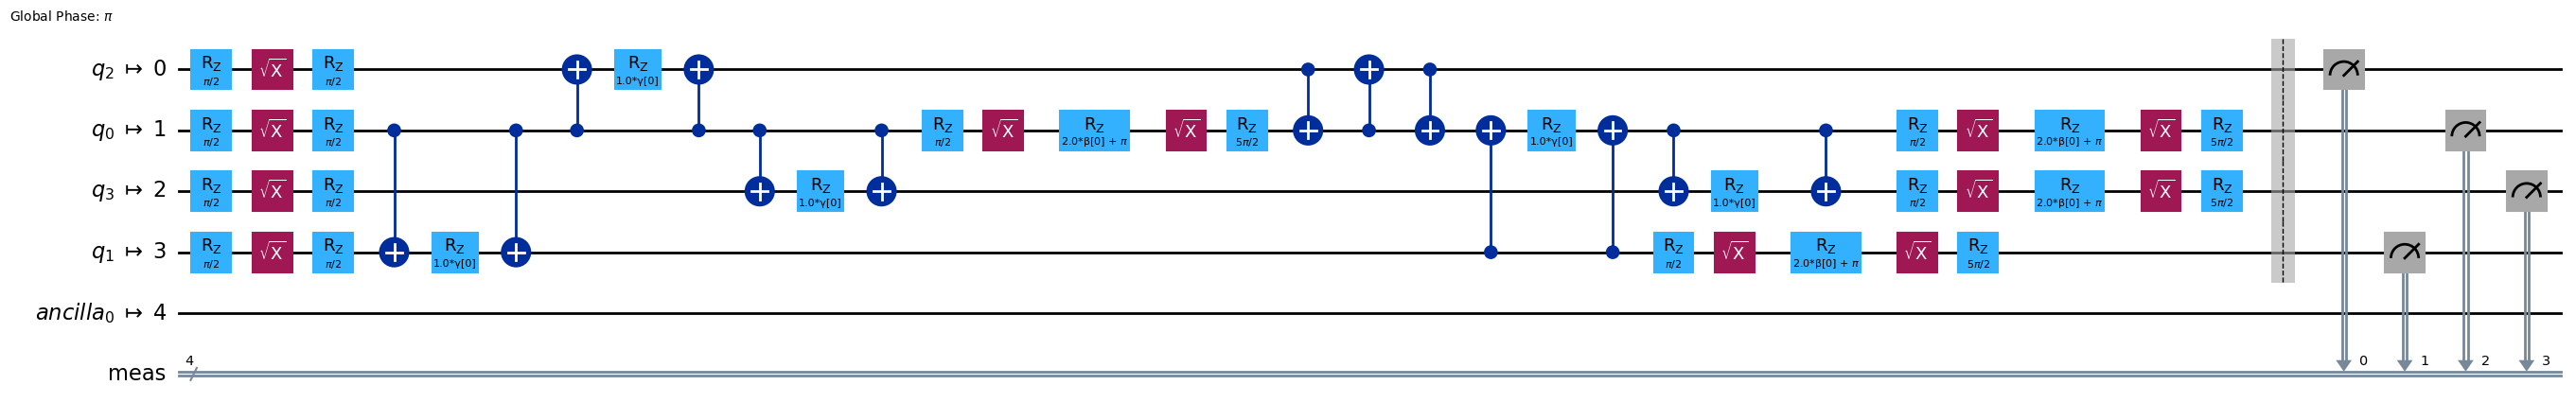

In [5]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from demo_src.transpile import transpile_abstract_circuit

backend = FakeVigoV2()
physical_ansatz = transpile_abstract_circuit(ansatz, backend)
physical_ansatz.draw('mpl', fold=False)

## 3. Execute using Qiskit Runtime primitives

We now want to find the best candidate solution for our optimization problem. For this, we use the following iterative process:

1. generate candidate parameter values for $\gamma_0$ and $\beta_0$
2. prepare quantum state and measure on a quantum computer
3. evaluate cost function using measured result
4. update the candidate parameters

The execution is done through the **cloud** using the **Qiskit IBM Runtime service**.

### Define backend and execution primitive

To interact with a IBM backends we use the **Qiskit Runtime Primitives**. There are two primitives: Sampler and Estimator, and the choice of primitive depends on the task that we want to run on the quantum computer. We are interesting in drawing samples from the quantum computer, so we will use the **Sampler**. 

The primitives enable different execution modes:

![<img src="Screenshot 2024-02-22 at 11.04.55.png" height="50"/>](attachment:b00a31fc-9e2c-4087-abe3-748527a87f66.png)

In [6]:
# For the first part of the demo we will use locally simulated devices.

from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.primitives import BackendSampler

backend = FakeVigoV2()
sampler = BackendSampler(backend=backend)

In [7]:
from demo_src.run import evaluate_cost
import numpy as np

# define cost function
def cost_func(params, ansatz, hamiltonian, sampler):

    job = sampler.run(ansatz, params)
    samples = job.result().quasi_dists[0]
    
    cost = evaluate_cost(samples, hamiltonian)
    return cost

### Run iterative optimization loop

In [8]:
from demo_src.run import run_minimization_loop

result = run_minimization_loop(cost_func, physical_ansatz, cost_hamiltonian, sampler)

In [9]:
print("Message:", result.message)
print("Gamma and beta values:", result.param_values)
print("Num. iterations: ", result.num_iter)

Message: Optimization terminated successfully.
Gamma and beta values: [3.93830898 4.16663886]
Num. iterations:  30


## 4. Post-process, return result in classical format

### Sample final candidate solution

The last step is to perform one final sampling with the candidate solution.

This means preparing a quantum state $\psi$ in the computer and then measuring it. A measurement will collapse the state into a single computational basis state, for example `010101110000...` which corresponds to a candidate solution $x$ to our initial optimization problem ($\max f(x)$ or $\min f(x)$ depending on the task).

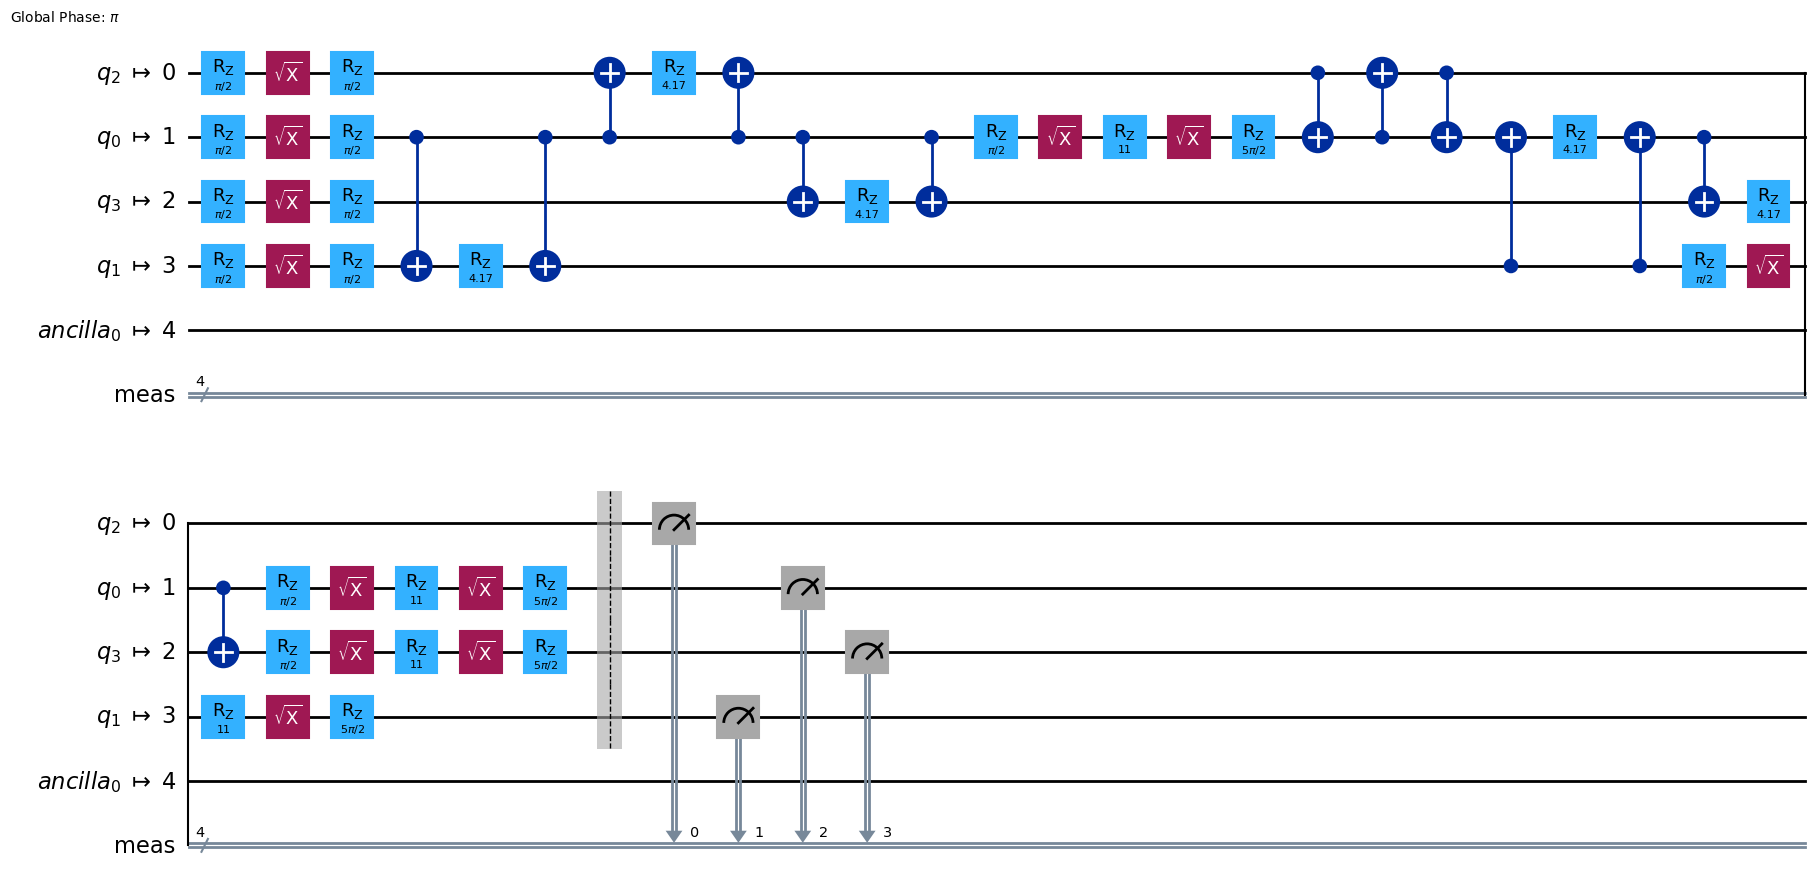

In [10]:
candidate_circuit = physical_ansatz.assign_parameters(result.param_values)

candidate_circuit.draw('mpl')

In [11]:
final_distribution = sampler.run(candidate_circuit, shots=int(1e4)).result().quasi_dists[0]

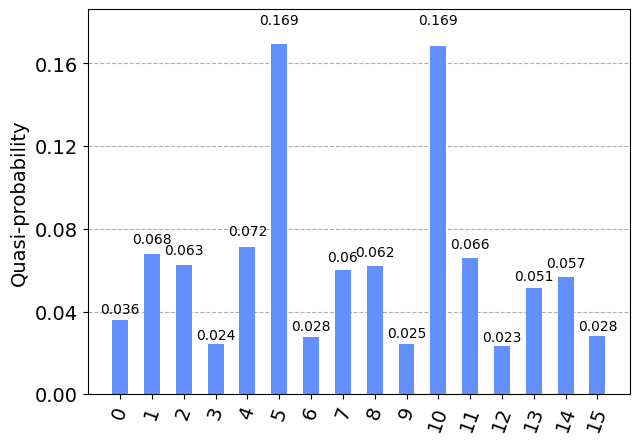

In [12]:
from qiskit.visualization import plot_distribution
plot_distribution(final_distribution)

In [13]:
from demo_src.post import sample_most_likely

best_result = sample_most_likely(final_distribution, len(demo_graph))
print("Result bitstring:", best_result)

Result bitstring: [1 0 1 1]


### Visualize best cut

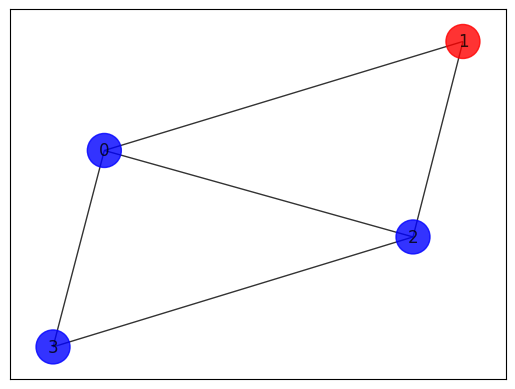

In [14]:
from demo_src.post import plot_result
plot_result(demo_graph, best_result)

---

# Part 2: Let's scale it up and run!


Let's try to solve Max-Cut on 127-node weighted graph, with both positive (green) and negative (red) weights.

![here](data/125node_example.png)

We have precomputed steps 1-3 for you, so you get to run step 4 on a real quantum device.

## 1. Map the classical inputs to a quantum problem

### Graph &rarr; QUBO

In [15]:
with open("data/125node_example.lp", "r") as file:
    problem = file.read()
print(problem)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 8 x0^2 + 8 x0*x1 + 8 x0*x13 - 8 x1^2 + 8 x1*x2 - 8 x2*x3 + 8 x3*x4
      - 4 x4^2 - 8 x4*x5 + 8 x4*x14 + 8 x5*x6 - 8 x6^2 + 8 x6*x7 - 8 x7^2
      + 8 x7*x8 - 12 x8^2 + 8 x8*x9 + 8 x8*x15 - 8 x9*x10 + 8 x10^2 - 8 x10*x11
      + 8 x11*x12 - 8 x12*x16 - 8 x13*x17 - 8 x14*x21 - 8 x15*x25 + 8 x16^2
      - 8 x16*x29 + 8 x17*x18 - 8 x18^2 + 8 x18*x19 + 4 x19^2 - 8 x19*x20
      - 8 x19*x32 + 8 x20*x21 - 4 x21^2 + 8 x21*x22 - 8 x22^2 + 8 x22*x23
      - 12 x23^2 + 8 x23*x24 + 8 x23*x33 - 8 x24^2 + 8 x24*x25 + 4 x25^2
      - 8 x25*x26 + 8 x26*x27 - 4 x27^2 + 8 x27*x28 - 8 x27*x34 - 8 x28*x29
      + 12 x29^2 - 8 x29*x30 + 8 x30^2 - 8 x30*x31 + 8 x31^2 - 8 x31*x35
      + 8 x32*x38 - 8 x33*x42 + 8 x34^2 - 8 x34*x46 + 8 x35^2 - 8 x35*x50
      - 8 x36^2 + 8 x36*x37 + 8 x36*x51 - 8 x37*x38 - 4 x38^2 + 8 x38*x39
      - 8 x39*x40 + 12 x40^2 - 8 x40*x41 - 8 x40*x52 + 8 x41^2 - 8 x41*x42
     

### QUBO &rarr; Hamiltonian

In [16]:
with open("data/125node_example_ising.txt") as input_file:
    for _ in range(10):
        print(str(next(input_file)).replace("\n", ""))

IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII, -1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII, -1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII, 1.0
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## 2. Optimize problem for quantum execution


In [17]:
from qiskit import qpy  # QPY is the circuit serializer in Qiskit.

# Load the circuits
team = 1  # Fill in your team here, either 1 or 2
if team == 1:
    backend_type = "eagle"
elif team == 2:
    backend_type == "heron"
else:
    raise ValueError("team should be 1 or 2.")

# Depth zero-circuit
with open(f"data/125node_{backend_type}_depth_zero.qpy", "rb") as fd:
    depth_zero_circuit = qpy.load(fd)[0]

# Depth one-circuit
with open(f"data/125node_{backend_type}_depth_one.qpy", "rb") as fd:
    depth_one_circuit = qpy.load(fd)[0]

In [18]:
print(depth_one_circuit)

          ┌─────────────────┐  ┌────────┐   ┌────┐               ┌──────┐     »
     q_0: ┤ Delay(3200[dt]) ├──┤ Rz(-π) ├───┤ √X ├───────────────┤1     ├─────»
          ├─────────────────┤ ┌┴────────┤   ├────┤  ┌──────┐     │      │     »
     q_1: ┤ Delay(2944[dt]) ├─┤ Rz(π/2) ├───┤ √X ├──┤0     ├─────┤      ├─────»
          ├─────────────────┤ └──┬────┬─┘┌──┴────┴─┐│  Ecr │     │      │     »
     q_2: ┤ Delay(2944[dt]) ├────┤ √X ├──┤ Rz(π/2) ├┤1     ├─────┤      ├─────»
          ├─────────────────┤    ├───┬┘  ├─────────┤└──────┘     │      │     »
     q_3: ┤ Delay(8256[dt]) ├────┤ X ├───┤ Rz(π/2) ├─────────────┤      ├─────»
          ├─────────────────┤  ┌─┴───┴──┐└──┬────┬─┘┌──────┐     │      │     »
     q_4: ┤ Delay(2944[dt]) ├──┤ Rz(-π) ├───┤ √X ├──┤1     ├─────┤      ├─────»
          ├─────────────────┤  └─┬───┬──┘┌──┴────┴─┐│  Ecr │     │      │     »
     q_5: ┤ Delay(2944[dt]) ├────┤ X ├───┤ Rz(π/2) ├┤0     ├─────┤      ├─────»
          ├─────────────────┤  ┌─┴───┴──

## 3. Execute using Qiskit Runtime Primitives

Tu run QAOA we need to know the optimal parameters $\gamma_k$ and $\beta_k$ to put in the variational circuit. We will not optimize these parameters here. We will simply assume that someone has done this for us. The optimal parameters to use are

* Depth-zero QAOA: none
* Depth-one optimal (gamma, beta): (0.3927, 0.3927)  **# TODO need to check these**

Note that findin gsuch parameters is a research field in itself.

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Backend for team 1
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend('ibm_sherbrooke')

# Backend for team 2
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend('ibm_torino')

In [20]:
from qiskit_ibm_runtime import Sampler, Options

# Since we have already done the transpilation we can skip it.
options = Options()
options.transpilation.skip_transpilation = True

sampler = Sampler(backend=backend, options=options)

### Bind the parameters for the depth-one ansatz

As mentioned above, the depth-one QAOA circuit has two parameters $\gamma$ and $\beta$ that need to be bound before we can run the circuits.

In [21]:
depth_one_circuit.parameters

ParameterView([Parameter(β1), Parameter(γ1)])

In [22]:
depth_one_bound_circuit = depth_one_circuit.assign_parameters([0.3927,  0.3927], inplace=False)

### Sample candidate solution from backend

In [23]:
# sampler_job = sampler.run([depth_one_bound_circuit, depth_zero_circuit])

Each call to the sampler returns a JobId that we can use to retrive the results when they are ready.

In [24]:
sampler_job.job_id()

NameError: name 'sampler_job' is not defined

In addition, we can check the status of our jobs to see if they are finished.

In [ ]:
sampler_job.status()

## 4. Post-process, return result in classical format

Now, we need to see which candidate solutions returned to us by the backend did well.

**TODO** Make a plot of the samples of depth one and depth two.

## Appendix A: Reformulation in spin variables

Here, we rewrite the QUBO $x^TQx$ in terms of spin-variables $x_i=(1-z_i)/2$.
\begin{align}
x^TQx=\sum_{ij}Q_{ij}x_ix_j=\frac{1}{4}\sum_{ij}Q_{ij}(1-z_i)(1-z_j)=\frac{1}{4}\sum_{ij}Q_{ij}z_iz_j-\frac{1}{4}\sum_{ij}(Q_{ij}+Q_{ji})z_i + \frac{n^2}{4}.
\end{align}
If we write $b_i=-\sum_{j}(Q_{ij}+Q_{ji})$ and remove the prefactor and the constant $n^2$ term we arrive at the two equivalent formulations of the same optimization problem
\begin{align}
\max_{x\in\{0,1\}^n} x^TQx\Longleftrightarrow \max_{z\in\{-1,1\}^n}z^TQz + b^Tz
\end{align}

## Appendix B: Quantum notation

The $Z$ matrices are imbedded in the quantum computer's computational space, i.e., a Hilbert space of size $2^n\times 2^n$. Therefore, you should understand terms such as $Z_iZ_j$ as the tensor product $Z_i\otimes Z_j$ imbedded in the $2^n\times 2^n$ Hilbert space. For example, in a problem with five decision variables the term $Z_1Z_3$ is understood to mean $I\otimes Z_3\otimes I\otimes Z_1\otimes I$ where $I$ is the $2\times 2$ identity matrix.